In [1]:
!pip install emoji

     |████████████████████████████████| 175 kB 8.5 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=f43b3459e25eec07e3f102c4cc51098495afa912a604742d3994ea09a3c7d9b1
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [2]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sb

import os
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB,BernoulliNB

import re
import emoji

from collections import Counter
from sklearn.datasets import make_classification

from imblearn.under_sampling import RandomUnderSampler
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from nltk import FreqDist
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from google.colab import files
uploaded=files.upload()

Saving offenseval-training-v1.tsv to offenseval-training-v1.tsv


In [4]:
train_data = pd.read_csv('offenseval-training-v1.tsv' , sep='\t')
train_data.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         13240 non-null  int64 
 1   tweet      13240 non-null  object
 2   subtask_a  13240 non-null  object
 3   subtask_b  4400 non-null   object
 4   subtask_c  3876 non-null   object
dtypes: int64(1), object(4)
memory usage: 517.3+ KB


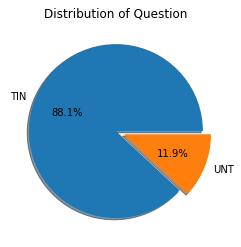

In [6]:
ax=train_data['subtask_b'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%' ,shadow=True)
ax.set_title('Distribution of Question')
ax.set_ylabel('')
plt.show()

Targeted:  524
Un Targeted:  3876


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


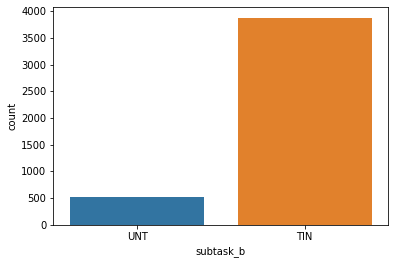

In [7]:
plot_sb = sb.countplot(train_data['subtask_b'], label='Total')
unTargeted, targeted = train_data['subtask_b'].value_counts()
print('Targeted: ', targeted )
print('Un Targeted: ',unTargeted)

In [8]:
def handle_emoji(text):
    # Dictionnary of "important" emojis : 
    emoji_dict =  {'♥️': ' love ',
                   '❤️' : ' love ',
                   '❤' : ' love ',
                   '😘' : ' kisses ',
                  '😭' : ' cry ',
                  '💪' : ' strong ',
                  '🌍' : ' earth ',
                  '💰' : ' money ',
                  '👍' : ' ok ',
                   '👌' : ' ok ',
                  '😡' : ' angry ',
                  '🍆' : ' dick ',
                  '🤣' : ' haha ',
                  '😂' : ' haha ',
                  '🖕' : ' fuck you '}

    for cha in emoji_dict:
        text = re.compile(str(cha)).sub(str(emoji_dict[cha]),text)
    # Remove ALL emojis
    text = emoji.get_emoji_regexp().sub(r' ',text) 
    text = re.compile("([\U0001f3fb-\U0001f3ff])").sub(r'',text) 
    text = re.compile("([\U00010000-\U0010ffff])").sub(r'',text) 
    text = re.compile("(\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff])").sub(r'',text)

    # Add Space between  the Emoji Expressions : 
    text = re.compile("([\U00010000-\U0010ffff])").sub(r' \1 ',text) 
    return text

In [9]:
def clean_tweet(text):
    ''' Function that is applied to every to tweet in the dataset '''

    # =========== TEXT ===========
    # Replace @USER by <user>
    text = re.compile(r'@USER').sub(r'<user>',text)

    # Replace URL by <url>
    text = re.compile(r'URL').sub(r'<url>',text)

    # Remove numbers :
    text = re.compile(r'[0-9]+').sub(r' ',text)

    # Remove some special characters
    text = re.compile(r'([\xa0_\{\}\[\]¬•$,:;/@#|\^*%().~`”"“-])').sub(r' ',text) 

    # Space the special characters with white spaces
    text = re.compile(r'([$&+,:;=?@#|\'.^*()%!"’“-])').sub(r' \1 ',text)

    # Replace some special characters : 
    replace_dict = {r'&' : 'and' , r'&amp;' : 'and' , 
                    r'\+' : 'plus'}
    for cha in replace_dict:
        text = re.compile(str(cha)).sub(str(replace_dict[cha]),text)

    # Handle Emoji : translate some and delete the others
    text = handle_emoji(text)

    # Word delengthening : 
    text = re.compile(r'(.)\1{3,}').sub(r'\1\1',text)

    # Cut the words with caps in them : 
    text = re.compile(r'([a-z]+|[A-Z]+|[A-Z][a-z]+)([A-Z][a-z]+)').sub(r'\1 \2',text)
    text = re.compile(r'([a-z]+|[A-Z]+|[A-Z][a-z]+)([A-Z][a-z]+)').sub(r'\1 \2',text)        
    # =========== TOKENS ===========
    # TOKENIZE 
    text = text.split(' ')

    # Remove white spaces tokens
    text = [text[i] for i in range(len(text)) if text[i] != ' ']

    # Remove empty tokens
    text = [text[i] for i in range(len(text)) if text[i] != '']

    # Remove repetition in tokens (!!! => !)
    text = [text[i] for i in range(len(text)) if text[i] != text[i-1]]

    #  Handle the ALL CAPS Tweets 
    ### if ratio of caps in the word > 75% add allcaps tag <allcaps>
    caps_r = np.mean([text[i].isupper() for i in range(len(text))])
    if caps_r > 0.6 : 
        text.append('<allcaps>')

    # Lower Case : 
    text = [text[i].lower() for i in range(len(text))]
    
    return " ".join(str(x) for x in text)

In [10]:
train_data['subtask_b'].replace({'UNT':0, 'TIN': 1}, inplace= True)

In [11]:
train_data["preprocessed_tweet"] = train_data["tweet"].apply(clean_tweet)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'


In [12]:
train_data.head()

,id,tweet,subtask_a,subtask_b,subtask_c,preprocessed_tweet
0,86426,@USER She should ask a few native Americans wh...,OFF,0.0,NaN,<user> she should ask a few native americans w...
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1.0,IND,<user> go home you re drunk ! <user> maga trum...
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,amazon is investigating chinese employees who ...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,0.0,NaN,<user> someone should ' ve taken this piece of...
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,<user> obama wanted liberals and amp illegals ...


In [13]:
train_data = train_data.dropna(subset=['subtask_b'])

In [14]:
train_data.shape

(4400, 6)

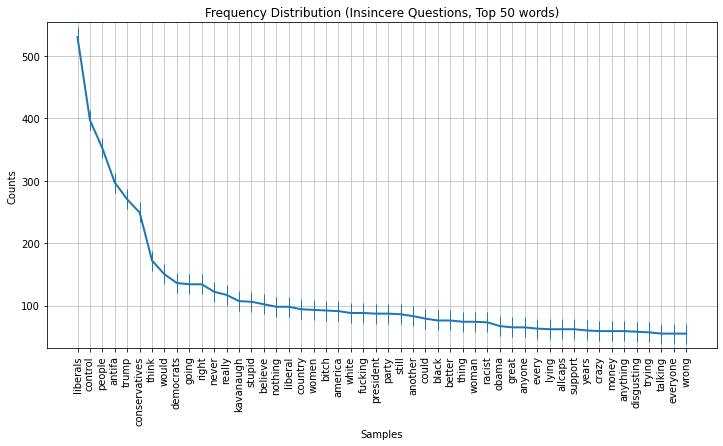

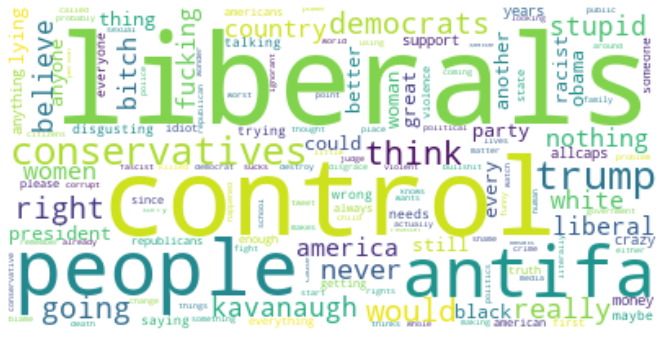

In [15]:
offensive = train_data.loc[train_data['subtask_b'] == 1].values
len(offensive)
offensive[0][1]

stop_words = set(stopwords.words('english'))
word_tokens = [word_tokenize(question[5]) for question in offensive]

#freq_dist = FreqDist([word for question in insincere_questions for word in question[1].split()])
all_words = [word for question in word_tokens for word in question]
len(all_words)
without_stopwords = [w for w in all_words if not w in stop_words]
words_len = [w for w in without_stopwords if not len(w)<5]
freq_dist = FreqDist([word for word in words_len])

plt.figure(figsize=(12,6))
plt.title(f'Frequency Distribution (Insincere Questions, Top 50 words)')
freq_dist.plot(50, marker='|', markersize=20)
plt.show()

from wordcloud import WordCloud

wordcloud = WordCloud(background_color='White').generate_from_frequencies(freq_dist)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [16]:
X = train_data["preprocessed_tweet"].values
y = train_data["subtask_b"].values
y

array([0., 1., 0., ..., 1., 1., 0.])

In [17]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, stratify=y, test_size=0.20)

In [18]:
print("Train shape : ",train_X.shape)
#print("Validation shape : ",val_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (3520,)
Test shape :  (880,)


In [19]:
unique, counts = np.unique(train_y, return_counts=True)
print(np.asarray((unique, counts)).T)

# unique, counts = np.unique(val_y, return_counts=True)
# print(np.asarray((unique, counts)).T)

unique, counts = np.unique(test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[0.000e+00 4.190e+02]
 [1.000e+00 3.101e+03]]
[[  0. 105.]
 [  1. 775.]]


In [20]:
testdf = pd.DataFrame()
testdf['tweet'] = test_X

testdf['subtask_b'] = test_y
testdf.shape

(880, 2)

In [21]:
def tfidf_vectorizer(X, train_X, test_X):
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer.fit(X)

    train_text_features_tf = tfidf_vectorizer.transform(train_X)
    test_text_features_tf = tfidf_vectorizer.transform(test_X)
    
    return train_text_features_tf, test_text_features_tf

In [22]:
def count_vectorizer(X, train_X, test_X):
    
    count_vectorizer = CountVectorizer()
    count_vectorizer.fit(X)

    train_text_features_cv = count_vectorizer.transform(train_X)
    test_text_features_cv = count_vectorizer.transform(test_X)
    
    return train_text_features_cv, test_text_features_cv

In [23]:
def undersampleData(train_text_features_tf, train_y):
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_resample(train_text_features_tf, train_y)
    return X_resampled, y_resampled

In [24]:
def oversampleData(train_text_features_tf, train_y):
    from imblearn.over_sampling import SMOTE
    smote = SMOTE('minority')
    x_oversampled, y_oversampled = smote.fit_sample(train_text_features_tf, train_y)
    return x_oversampled, y_oversampled

In [25]:
def getConfusionMatrix(y_test, y_pred):
  # Confusion matrix
  mat = confusion_matrix(y_test, y_pred)
  cm = pd.DataFrame(mat)
  TP = cm.iloc[1,1] # True Positive
  TN = cm.iloc[0,0] # True Negative
  FP = cm.iloc[0,1] # False Positive
  FN = cm.iloc[1,0] # False Negative

  print('Sensitivity: {:.2%}'.format(TP/(FN+TP)))
  print('Specificity: {:.2%}'.format(TN/(FP+TN)))
  
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
  plt.title('A confusion matrix showing the frequency of misclassifications by our classifier')
  plt.xlabel('true label')
  plt.ylabel('predicted label');
  plt.show()

In [26]:
def model(model, X, train_X, train_y, test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = False):
    
    if tfidf:
        print('Feature Extraction using TFIFD')
        train_text_features, test_text_features = tfidf_vectorizer(X, train_X, test_X)
    
    if cv:
        print('Feature Extraction using CV')
        train_text_features, test_text_features = count_vectorizer(X, train_X, test_X)

    if undersampled:
        print('Undersampling the dataset')
        train_text_features, train_y = undersampleData(train_text_features, train_y)

    if oversample:
        print('Oversampling the dataset')
        train_text_features, train_y = oversampleData(train_text_features, train_y)
        
    model.fit(train_text_features, train_y)

    # predict the labels on validation dataset
    predictions = model.predict(test_text_features)

    # Use accuracy_score function to get the accuracy
    print("Accuracy Score -> ",accuracy_score(predictions, test_y)*100)

    print('F1Score', f1_score(predictions, test_y, average="macro"))
    print('Precision', precision_score(predictions, test_y, average="macro"))
    print('Recall', recall_score(predictions, test_y, average="macro"))

    getConfusionMatrix(test_y, predictions)

Feature Extraction using TFIFD
Undersampling the dataset
Accuracy Score ->  75.0
F1Score 0.5798611111111112
Precision 0.6316436251920123
Recall 0.5749256863087953
Sensitivity: 78.71%
Specificity: 47.62%


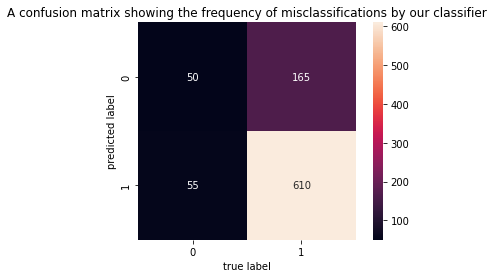

In [27]:
model(naive_bayes.MultinomialNB(), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = True, oversample = False)

Feature Extraction using TFIFD
Undersampling the dataset
Accuracy Score ->  66.02272727272728
F1Score 0.5317141235034589
Precision 0.6218433179723502
Recall 0.5557887510972069
Sensitivity: 67.23%
Specificity: 57.14%


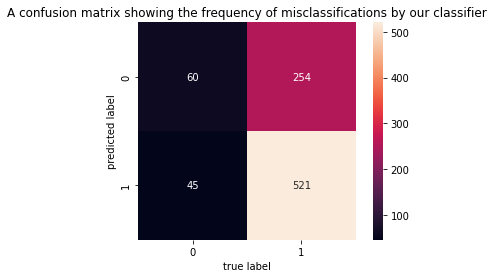

In [28]:
model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = True, oversample = False)

Feature Extraction using CV
Undersampling the dataset
Accuracy Score ->  55.45454545454545
F1Score 0.47745684353395257
Precision 0.6235944700460829
Recall 0.5519523118326781
Sensitivity: 53.29%
Specificity: 71.43%


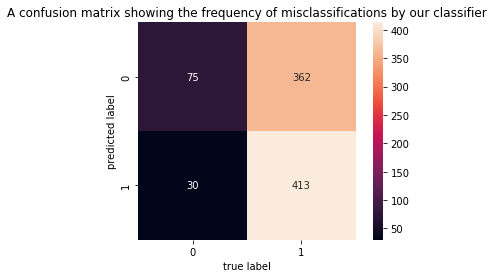

In [29]:
from sklearn.ensemble import RandomForestClassifier

model(RandomForestClassifier(n_estimators=100, max_depth=4,random_state=0), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = True, oversample = False)

Feature Extraction using TFIFD
Undersampling the dataset
Accuracy Score ->  66.13636363636364
F1Score 0.5309638278388278
Precision 0.6183717357910906
Recall 0.5544335128476088
Sensitivity: 67.48%
Specificity: 56.19%


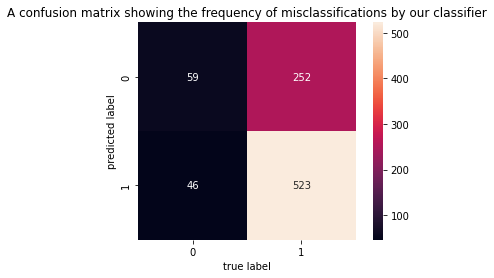

In [30]:
from sklearn.linear_model import LogisticRegression

model(LogisticRegression(), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = True, oversample = False)